In [ ]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats

In [ ]:
# Loading files and setting the desired year

CHECKIN_FILE_2023 = r"data\Translink_data\2023 transline.txt"
TEMP_FILE_2023 = r"data\Translink_data\Daily rainfall and tempratur2023.txt"
YEAR = 2023

In [3]:
# Function for loading the Translink data
def load_checkin_weekly(file_path, target_year):
    
    # If the file path doesnt exist, raise an Error
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Check-in file not found: {file_path}")

    # Error proof - reading the file and assigning it into a df variable
    try:
        df = pd.read_csv(file_path, sep=';', decimal='.', usecols=['Datum', 'Uur', 'Aantal_check_ins'])
    # Else raise exception if file not found/doesnt exist
    except Exception as e:
        print(f"Error reading check-in file {file_path}: {e}")
        return None
    
    # Convert "Datum" and "Uur" columns to a datatime object
    df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['Uur'].astype(str), format='%d-%m-%Y %H', errors='coerce')
    df.set_index('Datetime', inplace=True)

    # Setting up the dataframe to contain only the desired year to the input from above (YEAR variable)
    df_year = df[df.index.year == target_year].copy()
    
    # Converting the hourly data into daily
    df_daily = df_year['Aantal_check_ins'].resample('D').sum()

    # Return a formated df with no NaN values
    return df_daily.resample('W').sum().dropna()

In [ ]:
# Function for loading KNMI data, converting precipitation
def load_rain_weekly(file_path, target_year):

    # If the file path doesnt exist, raise an Error
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Weather file not found: {file_path}")
    
    # Get particular columns (Date and RH) and drop NaN values from them
    try:
        df_rain = pd.read_csv(
            file_path, 
            skiprows=8, 
            sep=r'\s*,\s*', 
            engine='python',
            header=None,
            usecols=[1, 3], 
            names=['DATE', 'RH']
        ).dropna(subset=['DATE', 'RH'])
  
        # Correctly formating date and RH values
        df_rain['DATE'] = pd.to_numeric(df_rain['DATE'], errors='coerce')
        df_rain['RH'] = pd.to_numeric(df_rain['RH'], errors='coerce').replace(-1, 0) 
        df_rain.replace(-9999, np.nan, inplace=True) 

        # Turn Date into datetime object
        df_rain['Datetime'] = pd.to_datetime(df_rain['DATE'].astype(str), format='%Y%m%d', errors='coerce')
        df_rain.set_index('Datetime', inplace=True)
     
        # Assign df_rain to df_year and select only the target_year as year of the database
        df_year = df_rain[df_rain.index.year == target_year].copy()

        # Convert the rain correctly (from KNMI description)
        daily_total_rain = df_year['RH'] / 10

        # Return a formated df for rain with no NaN values
        return daily_total_rain.resample('W').sum().dropna()
    
    # Else raise and exception if there is an error - for example if the given columns don't exist 
    except Exception as e:
        print(f"Critical error processing weather file {file_path}: {e}")
        return None


In [ ]:
# Function for creating the scatter plot
def scatter_rain_vs_checkin_weekly(checkin_w, rain_w, year: int):

    # Combining the datasets
    combined_data = pd.concat([checkin_w.rename('Total_Check_ins'), rain_w.rename('Total_Rain')], axis=1).dropna()

    # setting axis
    X = combined_data['Total_Rain']    
    Y = combined_data['Total_Check_ins']

    # Get Pearsons correlation coefficient and the R^2
    r, p_value = stats.pearsonr(X.values, Y.values)
    R_squared = r**2

    # Creating the equation for the linear fit
    coefficients = np.polyfit(X, Y, 1) 
    polynomial = np.poly1d(coefficients)

    # Getting the beginning of the line and the end, x_fit is an array of 100 values in between
    # This is done to make sure the curves of the fit are represented, although it is a linear regression so
    # inherently it is supposed to be a line
    X_min, X_max = X.min(), X.max()
    x_fit = np.linspace(X_min, X_max, 100) 

    # Creating a figure
    fig, ax = plt.subplots(figsize=(10, 7))

    # The figure is scatter plot
    ax.scatter(X, Y, color='tab:blue', s=60, alpha=0.7, label=f'Weekly Check-ins (Data Points)') 
    
    # Formating labels for the description on the bottom left (in the legend)
    fit_label = (f'Linear Fit: y={coefficients[0]:.2f}x + {coefficients[1]:.2f}'
                 f' ($R^2$={R_squared:.3f})'
                  f' ($R$={r:.3f})')

    # Creating the linear correlation line              
    ax.plot(x_fit, polynomial(x_fit), color='tab:red', linestyle='-', linewidth=2, label=fit_label) 

    # Set the limit of the y axis to start from 0
    ax.set_ylim(bottom=0)
    
    # Labeling axes
    ax.set_xlabel('Weekly Total Rainfall (mm)', fontsize=12)
    ax.set_ylabel('Weekly Total Check-ins', fontsize=12)
    
    # Formating of how the plot looks, printing the result
    ax.legend(loc='best', fontsize=10)
    ax.set_title(f'{year} Full Year: Weekly Total Check-ins vs Weekly Total Rainfall', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6) 
    plt.tight_layout()
    plt.show()

In [ ]:
# Main function that is running when starting the code
def main_analysis_weekly_full_year():
    
    print(f"Processing weekly data for the full year {YEAR}...")
    
    try:
        # Loading all data through the functions
        checkin_w = load_checkin_weekly(CHECKIN_FILE_2023, YEAR)
        rain_w = load_rain_weekly(TEMP_FILE_2023, YEAR)
        
        # Error prevention if the data for the year is missing
        if checkin_w is None or rain_w is None or checkin_w.empty or rain_w.empty:
            print(f"Skipping {YEAR} analysis due to incomplete or missing data for the target year.")
            return

        # Call the function to plot
        scatter_rain_vs_checkin_weekly(checkin_w, rain_w, YEAR)
        
        print(f"\nAnalysis complete for {YEAR} full year.")
        print(f"Total weeks plotted: {len(checkin_w.index.intersection(rain_w.index))}") 
        
    # Else raise error if file is not found or anything else arises
    except FileNotFoundError as e:
        print(f"File not found error:{e}")
    except Exception as e:
        print(f"Error:{e}")

Processing weekly data for the full year 2023...


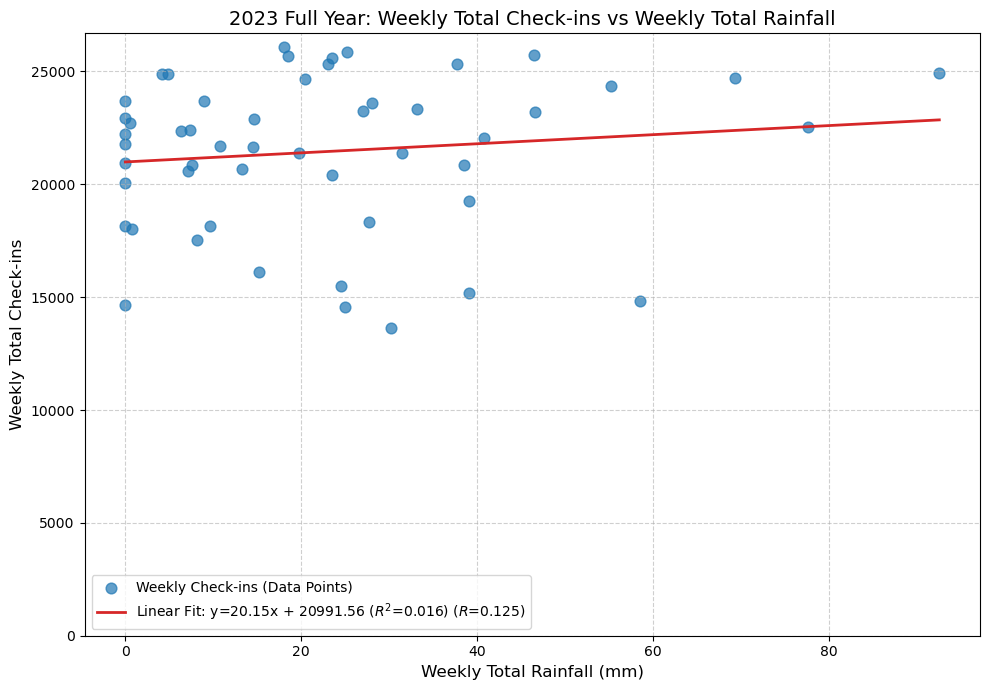


Analysis complete for 2023 full year.
Total weeks plotted: 52


In [ ]:
# Start of the code - calls the main function to run the code in a structured way
if __name__ == "__main__":
    main_analysis_weekly_full_year()